<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EA%B8%B0%EA%B3%84%EC%8B%9C%EC%84%A4%EB%AC%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 구조

2020-02-125.기계시설물고장예지_sample

> current
>>2.2kW
>>>L-DSF-01 정상, 축정렬불량  
>>>L-EF-04 정상, 회전체불평형  
>>>L-SF-04 정상, 베어링불량  
>>>R-EF-05 정상, 벨트느슨함  

>>55kW  
>>>L-PAHU-03S 정상, 회전체불평형  
>>>R-PAHU-04S 정상, 벨트느슨함  

>vibration
>>2.2kW  
>>55kW

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import unicodedata
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pickle
from itertools import permutations

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"
drive = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive/


### 피클 저장하기 (current 2.2kW만)

In [3]:
def load(num=1):

  corv='current'
  if num not in [1,2,3]: return None

  df_정상=pd.DataFrame()
  df_고장=pd.DataFrame()
  
  i=1
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)

          types=unicodedata.normalize('NFC', types)

          if types=='정상': df_정상=pd.concat([df_정상, tmp[num]], axis=1) #추가
          else: df_고장=pd.concat([df_고장, tmp[num]], axis=1) #추가

          if i==1:
            res=machine+' '+types 
            print(i, res)
          elif res!=machine+' '+types: 
            res=machine+' '+types
            print(i, res)
          i+=1

  return df_정상, df_고장

In [ ]:
a, b = load()

In [6]:
a.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1,-0.640625,0.040039,0.720703,1.561523,2.122070,2.562500,2.762695,2.722656,2.882812,3.083008,...,-2.802734,-2.962891,-3.163086,-3.243164,-3.163086,-2.762695,-2.242188,-1.681641,-1.201172,-0.800781
1,2.802734,2.922852,3.123047,3.163086,3.083008,2.682617,2.162109,1.561523,1.121094,0.680664,...,-2.362305,-1.841797,-1.281250,-0.840820,-0.440430,0.120117,0.840820,1.561523,2.202148,2.682617
1,-3.283203,-3.203125,-2.722656,-2.122070,-1.441406,-1.000977,-0.600586,-0.280273,0.400391,1.201172,...,-0.160156,-0.880859,-1.681641,-2.442383,-2.762695,-2.842773,-2.722656,-2.722656,-2.922852,-3.203125
1,0.800781,0.360352,-0.280273,-1.081055,-1.801758,-2.322266,-2.642578,-2.722656,-2.722656,-2.882812,...,2.722656,2.842773,2.842773,3.002930,3.163086,3.243164,3.163086,2.682617,2.041992,1.441406
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
b.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
1,3.283203,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
1,-2.962891,-2.962891,-3.163086,-3.203125,-3.283203,-3.042969,-2.522461,-1.921875,-1.321289,-0.920898,...,2.722656,2.282227,1.641602,1.201172,0.720703,0.280273,-0.360352,-1.121094,-1.881836,-2.442383
1,3.163086,3.203125,3.163086,2.642578,2.162109,1.521484,1.081055,0.600586,0.240234,-0.480469,...,-1.561523,-1.041016,-0.640625,-0.160156,0.560547,1.321289,2.122070,2.602539,2.882812,3.002930
1,2.802734,2.842773,2.962891,3.163086,3.283203,3.243164,2.882812,2.282227,1.761719,1.161133,...,-3.123047,-2.722656,-2.162109,-1.641602,-1.161133,-0.720703,-0.200195,0.480469,1.281250,1.961914


In [ ]:
a.to_pickle(os.path.join(drive, '전류정상.pkl'))
b.to_pickle(os.path.join(drive, '전류고장.pkl'))

### 데이터 불러오기

데이터는 1초에 2000개씩 측정됨

In [22]:
a=pd.read_pickle(os.path.join(drive, '전류정상.pkl'))
b=pd.read_pickle(os.path.join(drive, '전류고장.pkl'))

print(a.shape, b.shape)

(906, 2000) (979, 2000)


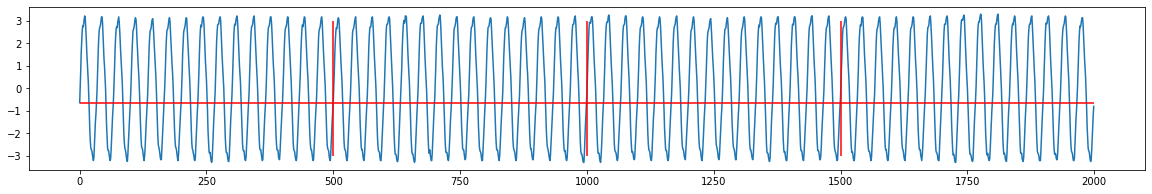

In [12]:
plt.figure(figsize=(20,3))
plt.plot(np.array(a.iloc[0]))
plt.hlines(a.iloc[0,0], 0, 2000, 'r')
plt.vlines([500, 1000, 1500], -3, 3, 'r')

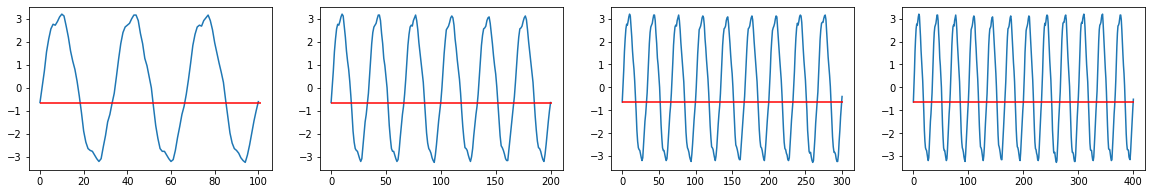

In [69]:
n=4
plt.figure(figsize=(20,3))
for i in range(1,n+1):
  plt.subplot(1,n,i)
  plt.plot(np.array(a.iloc[0][:100*i+1]))
  plt.hlines(a.iloc[0,0], 0, 100*i+1, 'r')
plt.show()

그래프와 같이, 교류는 코일이 회전하는 1바퀴를 1주기로 반복된다

3상 전력에는 RST상 또는 uvw상이 있고, 각 코일이 120도씩 배치되어 있어, 자기력선도 120도의 위상차를 가지며 주기를 반복하지만 [출처](https://findahobby.tistory.com/33)

나는 R상에 해당하는 데이터 하나만 사용했다

### 데이터 전처리

#### 1.증강

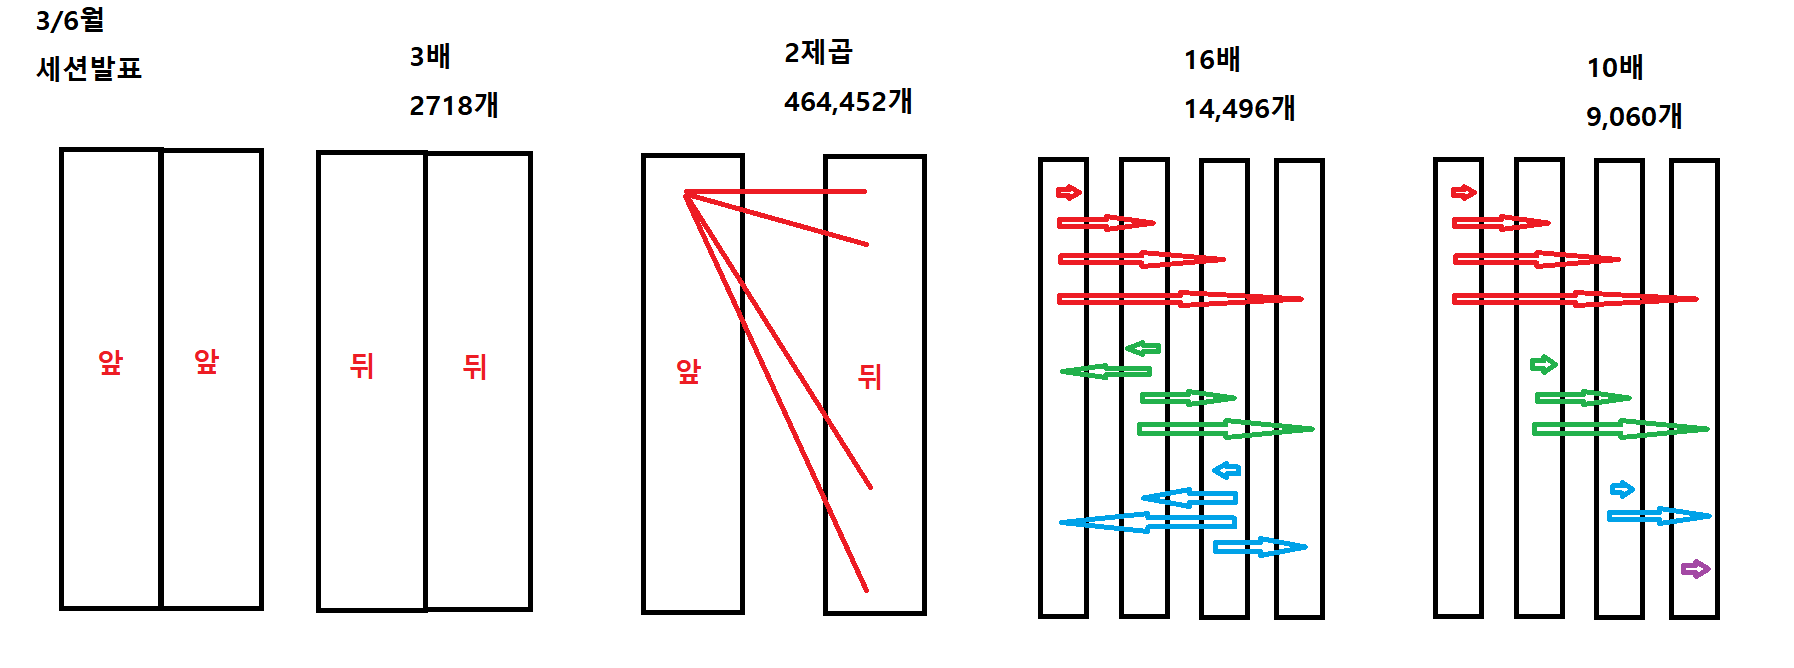

a_new 함수는

1. 정상데이터의 인덱스를 가져와 기계 종류별로 변수 4개에 저장 (LDSF01, LSF04, LEF04, REF05)

2. 열을 500개씩 잘라 변수 4개에 저장 (a1, a2, a3, a4)

3. 순열을 통해 데이터를 24배 증강 후 반환 (A)

기능을 하는 함수다



In [70]:
def a_new():

  global a

  idx={} #기계종류와 개수를 저장하는 딕셔너리
  
  for machine in os.listdir(file_path+'current/2.2kW'):
    i=0 #개수 초기화
    for types in os.listdir(file_path+'current/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      if types=='정상':
          for files in os.listdir(file_path+'current/2.2kW/'+machine+'/'+types):
            i+=1 
    machine=machine.replace('-','')
    idx[machine]=i

  print(idx)

  A = pd.DataFrame() #24배 증강된 데이터가 들어갈 데이터프레임

  name=list(idx.keys()) #기계종류=변수명
  count=list(idx.values()) #개수=인덱스
  count.insert(0,0)

  for i in range(4):
    globals()[name[i]] = a.iloc[count[i]:count[i]+count[i+1], :] #변수에 저장
    
    a1 = globals()[name[i]].iloc[:,:500]
    a2 = globals()[name[i]].iloc[:,500:1000]
    a3 = globals()[name[i]].iloc[:,1000:1500]
    a4 = globals()[name[i]].iloc[:,1500:]

    data = permutations([a1,a2,a3,a4], 4)

    for i,j,k,l in data:
      temp = pd.concat([i,j,k,l], axis=1).transpose().reset_index(drop=True).transpose()
      A = pd.concat([A, temp])

  return A.reset_index(drop=True)


In [71]:
%%time
a_fresh=a_new()

{'LDSF01': 97, 'LSF04': 77, 'LEF04': 667, 'REF05': 65}
CPU times: user 2.84 s, sys: 2.8 s, total: 5.64 s
Wall time: 5.66 s


In [72]:
print(a.shape, a_fresh.shape)

(906, 2000) (21744, 2000)


In [73]:
a = a_fresh

In [74]:
#정상 train/test
a_train, a_test = a[:20000], a[20000:]

#고장 test
ab=pd.DataFrame() #논문에서 본 방식대로, 정상데이터와 고장데이터를 이어 붙인다

aa=a.sample(n=979) #고장데이터 개수에 맞춰 979개를 랜덤 추출한다

a_=aa.iloc[:,:1000].reset_index(drop=True) #정상 앞
_a=aa.iloc[:,1000:].reset_index(drop=True)
b_=b.iloc[:,:1000].reset_index(drop=True) #고장 앞
_b=b.iloc[:,1000:].reset_index(drop=True)

for i in [a_,_a]:
  for j in [b_, _b]:
    temp=pd.concat([i, j], axis=1).transpose().reset_index(drop=True).transpose()
    ab=pd.concat([ab, temp])

#정상 train/valid
x_train, x_valid = train_test_split(a_train, test_size=0.2, random_state=0)

#test
x_test = pd.concat([a_test, ab]).reshape(5660) #정상 test와 고장 test
y_test = np.hstack((np.zeros(a_test.shape[0]), np.ones(ab.shape[0]))).reshape(-1,1) #0과 1


In [75]:
print('정상데이터', a.shape, '24배로 늘림'); print()
print('ㄴ학습', a_train.shape); print()
print('ㄴ테스트', a_test.shape); print()
print('고장데이터', b.shape); print()
print('ㄴ테스트', ab.shape, '4배로 늘림'); print()

정상데이터 (21744, 2000) 24배로 늘림

ㄴ학습 (20000, 2000)

ㄴ테스트 (1744, 2000)

고장데이터 (979, 2000)

ㄴ테스트 (3916, 2000) 4배로 늘림



In [76]:
print('Train set', x_train.shape); print()
print('Validation set', x_valid.shape); print()
print('Test set', x_test.shape); print()

Train set (16000, 2000)

Validation set (4000, 2000)

Test set (5660, 2000)



#### 2.정규화

In [99]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

stder = StandardScaler()
stder.fit(x_train) #stder를 a_train에 맞춤

a_train_scaled = stder.transform(x_train)
x_valid_scaled = stder.transform(x_valid)
x_test_scaled = stder.transform(x_test)

print(a_train_scaled.shape)
print(x_valid_scaled.shape)
print(x_test_scaled.shape)

(16000, 2000)
(4000, 2000)
(5660, 2000)


3. 스케일링

train/valid/test 데이터를 lstm 입력 형태로 맞추기 위해 3차원으로 차원을 변경함

In [100]:
# 복잡해 보이는거지 간단함

# X_scaled = X.reshape( X.shape[0], 1, X.shape[1] )

a_train_scaled = a_train_scaled.reshape(a_train_scaled.shape[0], 1, a_train_scaled.shape[1]) #차원 확장
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])

print(a_train_scaled.shape)
print(x_valid_scaled.shape)
print(x_test_scaled.shape)

(16000, 1, 2000)
(4000, 1, 2000)
(5660, 1, 2000)


#### 모델 구현

2개의 인코더와 2개의 디코더로 구성됨

In [79]:
from keras import regularizers
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model

def AE(x):
  inputs = Input(shape=(x.shape[1], x.shape[2]))

  L1=LSTM(140, activation='relu', return_sequences=True,
          kernel_regularizer=regularizers.l2(0.00))(inputs)

  L2=LSTM(70, activation='relu', return_sequences=False)(L1)

  L3=RepeatVector(x.shape[1])(L2)

  L4=LSTM(70, activation='relu', return_sequences=True)(L3)

  L5=LSTM(140, activation='relu', return_sequences=True)(L4)

  output = TimeDistributed(Dense(x.shape[2]))(L5)

  model = Model(inputs=inputs, outputs=output)

  return model

In [80]:
#모델 생성하고 컴파일

from keras.optimizers import Adam

model = AE(a_train_scaled)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2000)]         0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            1198960   
                                                                 
 lstm_1 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 70)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_3 (LSTM)               (None, 1, 140)            118160    
                                                             

#### 모델 학습

16분 걸림

In [82]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(a_train_scaled, a_train_scaled, epochs=100,
                    batch_size=64, validation_data=(x_valid_scaled, x_valid_scaled),
                    callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 26s 52ms/step - loss: 0.0907 - val_loss: 0.0219
Epoch 2/100
250/250 [==============================] - 14s 57ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 3/100
250/250 [==============================] - 10s 39ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 4/100
250/250 [==============================] - 11s 46ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 5/100
250/250 [==============================] - 11s 45ms/step - loss: 0.0200 - val_loss: 0.0195
Epoch 6/100
250/250 [==============================] - 9s 35ms/step - loss: 0.0198 - val_loss: 0.0193
Epoch 7/100
250/250 [==============================] - 8s 33ms/step - loss: 0.0194 - val_loss: 0.0189
Epoch 8/100
250/250 [==============================] - 9s 37ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 9/100
250/250 [==============================] - 8s 31ms/step - loss: 0.0180 - val_loss: 0.0173
Epoch 10/100
250/250 [==============================] - 10s 40ms/step - loss:

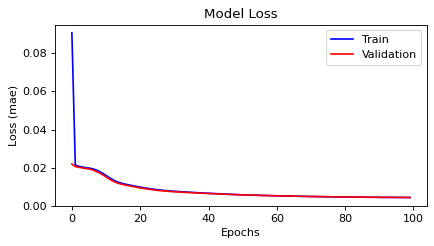

In [87]:
fig, ax = plt.subplots(figsize=(6,3), dpi=80)

ax.set_title('Model Loss')
ax.set_xlabel('Epochs'); ax.set_ylabel('Loss (mae)')

ax.plot( history.history['loss'], 'b', label='Train' )
ax.plot( history.history['val_loss'], 'r', label='Validation' )

ax.legend(loc='upper right')

plt.show()

In [111]:
#다시 차원 축소
pred_3d = model.predict(x_test_scaled)
pred = pred_3d.reshape(pred_3d.shape[0], pred_3d.shape[2])

mse=np.mean(np.power(x_test_ - pred, 2), axis=1)

177/177 [==============================] - 3s 16ms/step


In [118]:
df_error=pd.DataFrame({'Reconstruction_error': mse,
                       'True_class': y_test})

In [119]:
df_error

,Reconstruction_error,True_class
0,0.002380,0.0
1,0.002641,0.0
2,0.002406,0.0
3,0.002527,0.0
4,0.002627,0.0
...,...,...
5655,0.137511,1.0
5656,0.084378,1.0
5657,0.167852,1.0
5658,0.013304,1.0


In [120]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve

pre, re, thres = metrics.precision_recall_curve(df_error['True_class'], df_error['Reconstruction_error'])

best=abs(pre-re)
best=np.argmin(best)

print('precision:', pre[best], ', recall:', re[best])
print('threshold:', thres[best])

precision: 0.9785495403472931 , recall: 0.9785495403472931
threshold: 0.007529369643546122


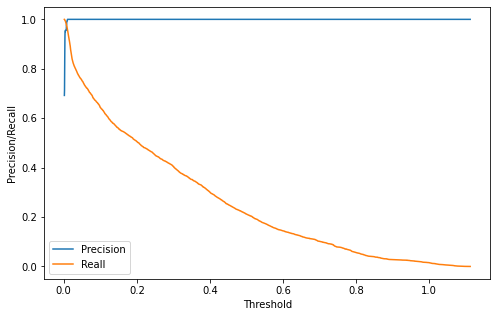

In [121]:
plt.figure(figsize=(8,5))
plt.plot(thres, pre[1:], label='Precision')
plt.plot(thres, re[1:], label='Reall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

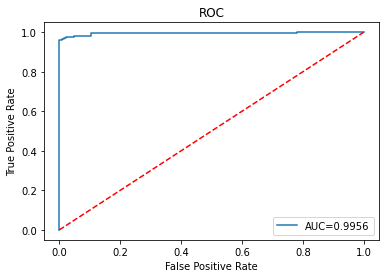

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, mse)
roc_auc=auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, label='AUC=%0.4f' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 1.데이터프레임 만들고 csv로 저장하기

load 함수
- x데이터 만드는 함수
- 모든 csv파일 불러와서 하나의 data frame으로 저장함 (변수: df)

label 함수
- y데이터 만드는 함수
- 각 csv파일 개수 가져와서 고장유형을 라벨링하는 array로 저장함 (변수: arr)
- 정상(0), 베어링불량(1), 벨트느슨함(2), 축정렬불량(3), 회전체불평형(4)

corv 파라미터
- current 또는 vibration

xc, yc, xv, yv 변수
- current와 vibration의 x데이터와 y데이터


In [ ]:
def load(corv):
  if corv not in ['current','vibration']: return None
  df=pd.DataFrame() 
  i=1 
  for machine in os.listdir(file_path+corv+'/2.2kW'):
      for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
        for files in os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types):
          tmp=pd.read_csv(file_path+corv+'/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9, header=None)
          if corv=='current': tmp=tmp.drop([0, 4],axis=1)
          elif corv=='vibration': tmp=tmp.drop([0, 2],axis=1)
          tmp=tmp.transpose()
          df=pd.concat([df, tmp])
          if i==1:
            res=machine+' '+types 
            print(i, res)
          elif res!=machine+' '+types: 
            res=machine+' '+types
            print(i, res)
          i+=1
  df=df.reset_index().drop(['index'], axis=1) 
  return df


def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3
      if types=='정상': tmp=np.zeros(mylen) 
      elif '베어링' in types: tmp=np.ones(mylen)*1 
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

In [ ]:
xc=load('current'); yc=label('current')
xv=load('vibration'); yv=label('vibration')

1 L-DSF-01 축정렬불량
365 L-DSF-01 정상
462 L-SF-04 정상
539 L-SF-04 베어링불량
739 L-EF-04 회전체불평형
968 L-EF-04 정상
1635 R-EF-05 벨트느슨함
1821 R-EF-05 정상
1 L-EF-04 정상
421 L-EF-04 회전체불평형
626 R-EF-05 벨트느슨함
819 R-EF-05 정상
895 L-SF-04 정상
979 L-SF-04 베어링불량
1219 L-DSF-01 축정렬불량
1426 L-DSF-01 정상


In [ ]:
xc.to_csv('/content/gdrive/MyDrive/CURRENT.csv')
xv.to_csv('/content/gdrive/MyDrive/VIBRATION.csv')

In [ ]:
xc.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
1,-1.361328,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
2,-2.762695,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3,3.283203,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
4,-2.882812,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680


In [ ]:
print("x데이터 구조:", xc.shape, xv.shape)
print("y데이터 분포:", len(yc), '->', [list(yc).count(i) for i in range(5)])
print("             ", len(yv), '->', [list(yv).count(i) for i in range(5)])

x데이터 구조: (5655, 2000) (1525, 12000)
y데이터 분포: 5655 -> [2718, 600, 558, 1092, 687]
              1525 -> [680, 240, 193, 207, 205]


## 2-1.y데이터

In [ ]:
def label(corv):
  if corv not in ['current','vibration']: return None
  i=0
  for machine in os.listdir(file_path+corv+'/2.2kW'):
    for types in os.listdir(file_path+corv+'/2.2kW/'+machine):
      types=unicodedata.normalize('NFC', types)
      mylen=len(os.listdir(file_path+corv+'/2.2kW/'+machine+'/'+types))
      if corv=='current': mylen*=3

      if types=='정상': tmp=np.zeros(mylen)
      elif '베어링' in types: tmp=np.ones(mylen)*1
      elif '벨트' in types: tmp=np.ones(mylen)*2
      elif '축' in types: tmp=np.ones(mylen)*3
      elif '회전체' in types: tmp=np.ones(mylen)*4
      if i==0: arr=tmp
      else: arr=np.hstack([arr,tmp])
      i+=1
  return arr

yc=label('current')
yv=label('vibration')

## 2-2.x데이터 불러와서 split하고 pickle로 저장하기(일단 전류만)

In [ ]:
#데이터프레임 다시 불러오기
raw=pd.read_csv('/content/gdrive/MyDrive/CURRENT.csv', index_col=0)

#라벨 추가하기
raw['label']=pd.DataFrame(yc)

#데이터셋 훈련, 검증, 테스트 분리하기
train, valid = train_test_split(raw, test_size=0.40, random_state=0, shuffle=True)
valid, test = train_test_split(valid, test_size=0.50, random_state=0, shuffle=True)

#데이터셋 x와 y 분리하기
train_x=train.iloc[:,:-1] #모든행, 라벨은 빼고
valid_x=valid.iloc[:,:-1]
test_x=test.iloc[:,:-1]
train_y=pd.DataFrame(train.iloc[:,-1]) #모든행, 라벨만
valid_y=pd.DataFrame(valid.iloc[:,-1])
test_y=pd.DataFrame(test.iloc[:,-1])

#피클로 저장하기
train_x.to_pickle(os.path.join(drive, 'xtrain.pkl')) #x피클
valid_x.to_pickle(os.path.join(drive, 'xvalid.pkl'))
test_x.to_pickle(os.path.join(drive, 'xtest.pkl'))
train_y.to_pickle(os.path.join(drive, 'ytrain.pkl')) #y피클
valid_y.to_pickle(os.path.join(drive, 'yvalid.pkl'))
test_y.to_pickle(os.path.join(drive, 'ytest.pkl'))

In [ ]:
print('Train:', train.shape, '->', train_x.shape, train_y.shape)
print('Valid:', valid.shape, '->', valid_x.shape, valid_y.shape)
print('Test :', test.shape, '->', test_x.shape, test_y.shape)

Train: (3393, 2001) -> (3393, 2000) (0, 1)
Valid: (1131, 2001) -> (1131, 2000) (0, 1)
Test : (1131, 2001) -> (1131, 2000) (0, 1)


In [ ]:
raw

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
0,3.042969,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,...,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578,3.0
1,-1.361328,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,...,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117,3.0
2,-2.762695,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,...,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789,3.0
3,3.283203,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,...,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969,3.0
4,-2.882812,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,...,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,2.522461,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,...,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461,0.0
5651,-2.882812,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,...,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562,0.0
5652,-2.602539,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,...,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852,0.0
5653,2.162109,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,...,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188,0.0


In [ ]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
3357,3.563477,3.803711,3.603516,3.683594,3.643555,3.443359,3.243164,2.802734,1.921875,1.081055,...,-3.563477,-2.842773,-1.921875,-1.241211,-0.400391,0.040039,0.760742,1.761719,2.642578,3.123047
1359,0.000000,0.480469,1.281250,1.921875,2.362305,2.682617,2.682617,2.682617,2.842773,2.882812,...,-2.922852,-3.042969,-3.083008,-3.163086,-2.922852,-2.482422,-1.961914,-1.281250,-0.840820,-0.400391
3416,-0.920898,-1.681641,-2.522461,-2.962891,-3.363281,-3.603516,-3.803711,-3.883789,-3.723633,-3.563477,...,3.683594,3.523438,3.323242,3.083008,2.362305,1.761719,0.960938,0.480469,0.000000,-0.680664
5213,-3.643555,-3.523438,-3.323242,-3.163086,-2.762695,-2.001953,-1.481445,-0.760742,-0.320312,0.280273,...,0.440430,-0.160156,-0.640625,-1.361328,-2.202148,-3.083008,-3.243164,-3.563477,-3.843750,-3.723633
3229,1.641602,0.880859,0.120117,-0.480469,-1.201172,-2.041992,-2.962891,-3.363281,-3.643555,-4.083984,...,3.042969,3.403320,3.563477,3.923828,4.324219,4.244141,3.963867,3.483398,3.243164,2.602539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,-3.483398,-3.363281,-3.203125,-3.203125,-2.802734,-2.282227,-1.721680,-1.041016,-0.640625,-0.080078,...,0.760742,0.200195,-0.320312,-0.920898,-1.681641,-2.442383,-3.123047,-3.323242,-3.523438,-3.803711
3264,-1.961914,-2.762695,-3.403320,-3.523438,-3.683594,-4.003906,-4.244141,-4.124023,-3.803711,-3.403320,...,3.843750,3.523438,3.163086,3.042969,2.522461,2.242188,1.121094,0.440430,-0.200195,-0.800781
1653,-3.838745,-4.399292,-4.359253,-4.599487,-4.599487,-4.519409,-3.918823,-3.718628,-2.917847,-2.397339,...,3.047974,2.847778,1.886841,1.366333,0.485474,-0.475464,-1.276245,-2.036987,-2.877808,-3.358276
2607,3.938843,3.898804,3.658569,3.338257,3.178101,2.537476,1.536499,0.695679,-0.025024,-0.545532,...,-2.267212,-1.426392,-0.785767,-0.305298,0.335327,1.136108,2.057007,2.537476,2.857788,3.178101


In [ ]:
train_y

,label
3357,0.0
1359,0.0
3416,0.0
5213,2.0
3229,0.0
...,...
4931,2.0
3264,0.0
1653,1.0
2607,4.0


## pickle 불러오기

pick 함수

- 피클 3개를 한번에 반환하는 함수
- 저장한 피클 불러와서 데이터프레임으로 토치로 변환하고 차원 증가함
- 파라미터로 'X'나 'Y'를 입력


In [ ]:
def pick(xory, tensor=0):
  if xory in ['X','x']: pickles=['xtrain.pkl','xvalid.pkl','xtest.pkl']
  elif xory in ['Y','y']: pickles=['ytrain.pkl','yvalid.pkl','ytest.pkl']
  else: return None
  res=[]
  for i in pickles:
    tmp=pd.read_pickle(os.path.join(drive, i))
    if tensor==0:
      tmp=torch.from_numpy(tmp.values)
      tmp=torch.unsqueeze(tmp, 1)
    res.append(tmp)
  return res[0], res[1], res[2]

In [ ]:
a,b,c=pick('X',1)
x,y,z=pick('Y',1)

In [ ]:
x[x['label']==3].index

Int64Index([ 149,  516,  946,  692,  289,   61,  832,  934,  589,  590,
            ...
             714,  544,  423,  659,  797,  755,   99,  537,  705, 1033],
           dtype='int64', length=679)

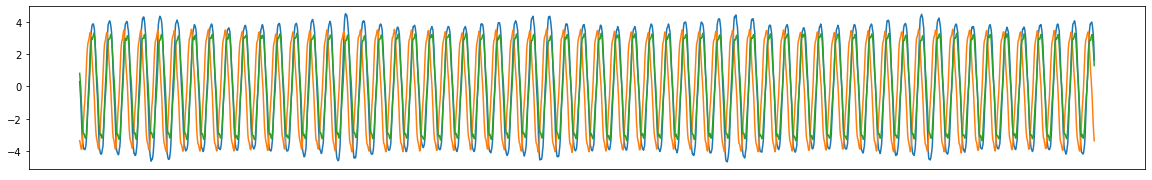

In [ ]:
plt.figure(figsize=(20,3))
i=149
plt.plot(a.iloc[i])
plt.plot(a.iloc[i+1])
plt.plot(a.iloc[i+2])
plt.gca().axes.xaxis.set_visible(False) #x축 이름 제거
plt.show()

In [ ]:
X_train, X_valid, X_test=pick('X')
Y_train, Y_valid, Y_test=pick('Y')

In [ ]:
print('Train:', X_train.shape, Y_train.shape)
print('Valid:', X_valid.shape, Y_valid.shape)
print('Test :', X_test.shape, Y_test.shape)

Train: torch.Size([3393, 1, 2000]) torch.Size([3393, 1])
Valid: torch.Size([1131, 1, 2000]) torch.Size([1131, 1])
Test : torch.Size([1131, 1, 2000]) torch.Size([1131, 1])


# ㅡㅡㅡㅡㅡ 옛날 코드 ㅡㅡㅡㅡㅡ

## 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import os
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/MyDrive/data/2020-02-125.기계시설물고장예지_sample/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(machine)

L-DSF-01
L-SF-04
L-EF-04
R-EF-05


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
    print(os.listdir(file_path+'current/2.2kW/'+machine))

['축정렬불량', '정상']
['정상', '베어링불량']
['회전체불평형', '정상']
['벨트느슨함', '정상']


In [ ]:
for machine in os.listdir(file_path+'current/2.2kW'):
  for types in os.listdir(file_path+'current/2.2kW/'+machine):
    print(len(os.listdir(file_path+'current/2.2kW/'+machine+'/'+types)))

364
97
77
200
229
667
186
65


## x데이터

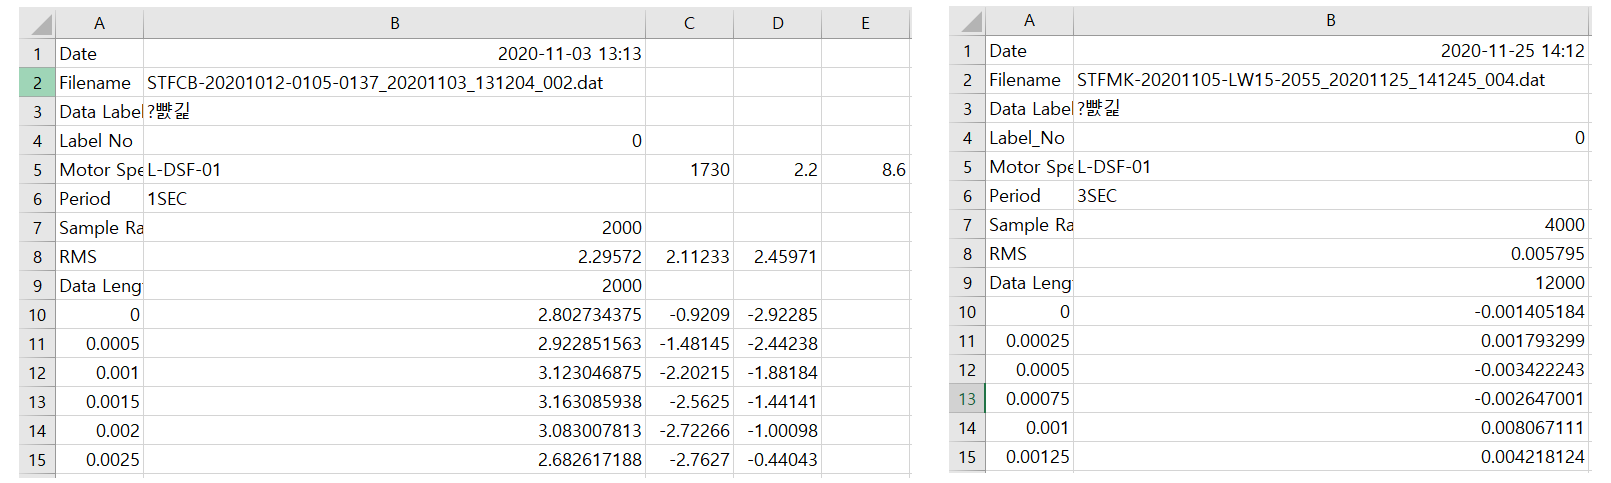

- df: 모든 csv파일 데이터를 담을 최종 data frame임
- - dfc: current
- - dfv: vibration
- i: 몇번째 저장 중인지 알려주는 인덱스임
- machine: 기계이름 가져옴
- types: 고장유형 가져옴
- files: 파일이름 가져옴
- tmp: csv파일 하나를 읽어와서 임시 저정하는 변수임, 9행까지는 skip함, 필요 없는 행 드롭함, 행열 뒤집음
- - dfc에서는 0열과 4열을 삭제
- - dfv에서는 0열과 2열을 삭제
- df: df에 tmp 결합함
- if: 실행확인을 위해 100 단위로 인덱스 출력함

In [ ]:
df=pd.DataFrame()
i=1 

for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    for files in os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types):
      tmp=pd.read_csv(file_path+'/current/2.2kW/'+machine+'/'+types+'/'+files, skiprows=9)
      tmp=tmp.drop(['0','Unnamed: 4'],axis=1)
      tmp=tmp.transpose()
      df=pd.concat([df, tmp])
      if i%100==0: print(i, machine, types)
      i+=1

100 L-DSF-01 축정렬불량
200 L-DSF-01 축정렬불량
300 L-DSF-01 축정렬불량
400 L-DSF-01 정상
500 L-SF-04 정상
600 L-SF-04 베어링불량
700 L-SF-04 베어링불량
800 L-EF-04 회전체불평형
900 L-EF-04 회전체불평형
1000 L-EF-04 정상
1100 L-EF-04 정상
1200 L-EF-04 정상
1300 L-EF-04 정상
1400 L-EF-04 정상
1500 L-EF-04 정상
1600 L-EF-04 정상
1700 R-EF-05 벨트느슨함
1800 R-EF-05 벨트느슨함


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
3.04296875,3.243164,3.323242,3.443359,3.042969,2.522461,1.881836,1.281250,0.800781,0.400391,-0.240234,...,-2.562500,-1.961914,-1.441406,-1.000977,-0.600586,0.040039,0.800781,1.601562,2.242188,2.642578
-1.361328125,-2.082031,-2.562500,-2.962891,-2.962891,-2.922852,-3.042969,-3.042969,-2.962891,-2.882812,-2.322266,...,2.722656,2.842773,2.842773,2.842773,2.762695,2.242188,1.641602,1.081055,0.520508,0.120117
-2.7626953125,-2.242188,-1.641602,-1.161133,-0.640625,0.080078,0.960938,1.721680,2.242188,2.682617,2.842773,...,-0.480469,-1.321289,-1.961914,-2.602539,-3.042969,-3.163086,-3.363281,-3.683594,-3.843750,-3.883789
3.283203125,3.042969,2.522461,1.921875,1.361328,0.880859,0.480469,-0.120117,-0.800781,-1.601562,-2.242188,...,-0.760742,-0.320312,0.320312,1.081055,1.921875,2.402344,2.802734,2.922852,2.922852,3.042969
-2.8828125,-2.922852,-2.882812,-2.882812,-2.922852,-2.922852,-2.882812,-2.362305,-1.721680,-1.161133,-0.640625,...,2.842773,2.682617,2.041992,1.441406,0.760742,0.320312,0.000000,-0.520508,-1.041016,-1.721680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.5224609375,1.961914,1.561523,1.000977,0.600586,0.040039,-0.640625,-1.321289,-1.641602,-2.082031,-2.602539,...,-0.480469,0.120117,0.600586,1.081055,1.521484,1.921875,2.322266,2.522461,2.562500,2.522461
-2.8828125,-3.042969,-3.083008,-3.002930,-2.882812,-2.762695,-2.602539,-1.961914,-1.561523,-1.081055,-0.600586,...,2.402344,1.961914,1.561523,1.201172,0.760742,0.280273,-0.280273,-0.800781,-1.241211,-1.601562
-2.6025390625,-2.242188,-1.921875,-1.561523,-1.121094,-0.600586,0.000000,0.640625,1.121094,1.561523,2.041992,...,-0.920898,-1.561523,-1.961914,-2.402344,-2.762695,-2.922852,-3.163086,-3.163086,-3.163086,-2.922852
2.162109375,2.402344,2.562500,2.682617,2.722656,2.522461,2.242188,1.921875,1.401367,1.081055,0.600586,...,-2.402344,-1.801758,-1.361328,-0.960938,-0.480469,0.240234,0.840820,1.521484,1.921875,2.242188


In [ ]:
df.to_csv('/content/gdrive/MyDrive/current.csv')

##
## df를 csv로 바꿔서 드라이브에 최종저장하는 것임!!! 한번만 실행!!!
##

## y데이터

- arr: 라벨 데이터를 담을 최종 array임
- mylist: 고장유형이랑 파일개수를 순서대로 저장하는 리스트임
- types: 아래의 오류 때문에 unicode 변환함
- - 오류: 한글이 같은데 == 결과가 false가 나옴, type은 str인데 1로 인덱싱 하니 첫글자가 아니라 자음이 나옴
- - 해결: https://jonsyou.tistory.com/26
- mylen
- for: step을 2로 해서 mylist에서 고장유형만 가져옴
- if: 고장유형이 정상이면 np.zeros()를 써서 0이 파일개수만큼 있는 array를 tmp에 저장함
- elif: 고장유형이 고장이면 np.ones()를 써서 1,2,3,4가 파일개수만큼 있는 array를 tmp에 저장함
-if: 첫번째면 arr에 tmp 대입함 (arr가 없기 때문에 아래 코드 쓰면 오류남)
-else: 아니면 arr에 tmp 이어붙이고 arr에 저장함

In [ ]:
mylist=[]
for machine in os.listdir(file_path+'/current/2.2kW'):
  for types in os.listdir(file_path+'/current/2.2kW/'+machine):
    types=unicodedata.normalize('NFC', types)
    mylen=len(os.listdir(file_path+'/current/2.2kW/'+machine+'/'+types))
    mylist.append(str(types))
    mylist.append(mylen)

print(mylist)

['축정렬불량', 364, '정상', 97, '정상', 77, '베어링불량', 200, '회전체불평형', 229, '정상', 667, '벨트느슨함', 186, '정상', 65]


In [ ]:
for i in range(0,len(mylist),2):
  print(i, mylist[i])
  if mylist[i]=='정상': tmp=np.zeros(mylist[i+1])
  elif '베어링' in mylist[i]: tmp=np.ones(mylist[i+1])*1
  elif '벨트' in mylist[i]: tmp=np.ones(mylist[i+1])*2
  elif '축' in mylist[i]: tmp=np.ones(mylist[i+1])*3
  elif '회전체' in mylist[i]: tmp=np.ones(mylist[i+1])*4
  if i==0: arr=tmp
  else: arr=np.hstack([arr,tmp])

0 축정렬불량
2 정상
4 정상
6 베어링불량
8 회전체불평형
10 정상
12 벨트느슨함
14 정상


In [ ]:
arr[300:600]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

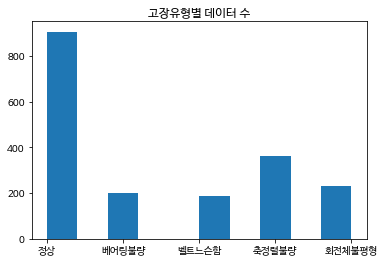

[906, 200, 186, 364, 229]

In [ ]:
plt.hist(list(arr))
plt.rc('font', family='NanumBarunGothic')
plt.title('고장유형별 데이터 수')
plt.xticks(range(5), ['정상','베어링불량','벨트느슨함','축정렬불량','회전체불평형'])
plt.show()

[list(arr).count(i) for i in range(5)]

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(df, arr, test_size=0.3, random_state=0)
